In [1]:
%config Completer.use_jedi = False

Run before benchmark if there is a GPU memory error, to run experiments using CPU device

In [2]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
import os
OUTPUT_DIR = os.path.join("lips", "Outputs")

In [5]:
import numpy as np
from pprint import pprint
from lips.dataset import DataSet
from lips.benchmark import Benchmark
from lips.evaluation import Evaluation
from lips.augmented_simulators import LeapNet
from lips.augmented_simulators import ResNetLayer

ModuleNotFoundError: No module named 'lips.agents'

# LIPS : Learning Industrial physical simulationbenchmark suite: the power grid case

The benchmarking platform (as it can be observed in the Figure below) is composed of three main modules: Data, Benchmarking and Evaluation. As the names suggest, each module is specialized with its own set of functions for a specific task. The Data module is the one that helps to generate different dataset and distributions providing a high flexibility using a set of parameters. Once the datasets are generated, the benchmarking platform will take as entry the generated dataset and perform a required benchmark on it. Each benchmark could be precised via the inputs and outputs required for modeling and prediction. Finally, in order to evaluate the performance of each benchmark, the Evaluation module provides a set of functions to inspect the models from different point of views (physics compliances, machine learning metrics, adaptability and readiness.  

The figure below presents the scheme of benchmarking platform which is composed of three distinct parts : 
* DataSet: Generate some dataset for training and evaluation 
* Benchmark: coordinates between different parts and allows train and evaluate an agumented simulator 
* Evaluation: once the benchmark done, it allow to evaluate the performance with respect to various point of views

![title](img/Benchmarking_scheme.png)

## Benchmark 1 : Risk assessment through contingency screening
The first power grid benchmark tackles the step of risk assessment in power grids. The problem is to anticipate potential threats on the power grid (several hours ahead) and warn the operators accordingly. It simulates incidents (aka contingencies) involving various elements of the grid (such as the disconnection of a line/production unit), one by one. For each contingency, a risk (weakness of the grid) is detected when overloads are detected by the simulation engine on some lines. On a real grid, this scenario means running several dozens of thousands of simulations, thereby, computation time is critical, especially since this risk assessment is refreshed every 15 minutes. In this benchmark, the main physical variable we are interested in is the value of electric current in the lines (in amperes), because an overload is detected if this value exceeds a line-dependent threshold.

In [2]:
import numpy as np
from pprint import pprint
from lips.dataset import DataSet
from lips.benchmark import Benchmark
from lips.evaluation import Evaluation
from lips.simulators import LeapNet
from lips.simulators import ResNetLayer

![title](img/Benchmarking_scheme.png)

In [3]:
# Run the cell below to produce a table of contents 
res = None
try:
    from jyquickhelper import add_notebook_menu
    res = add_notebook_menu()
except ModuleNotFoundError:
    print("Impossible to automatically add a menu / table of content to this notebook.\nYou can download \"jyquickhelper\" package with: \n\"pip install jyquickhelper\"")
res

## Scenario 1 : fully meshed network as reference topology

### Generate some data 
To be able to carry out benchmarks, it is necessary to generate some data at the first step. The `DataSet` class is the module designed for this purpose. It includes a set of parameters (number of samples) and functions (generate) to help generate a wide range of distributions over the different configurations of power networks. The user can select the power network environment for which the benchmark should be performed and set the desired input and output variables which should be considered for data generation (these are the parameters of `generate` function of this class which is the core function for generating data). The user could assign a tag to each generated dataset. A tag is assigned for a specific purpose. For example, a `training` tag suppose that the dataset will be used for training phase of a machine learning model (neural nets), and a `test` tag is used to evaluate the performance of such a model. Once the required datasets are generated, they could be accessed from a `Benchmark` class which takes as argument an object of `DataSet` class. All the meta-data and generated datasets could also be stored on disk (via `save` function) and to be reloaded afterwards (via `load` function by indicating the path).

***jerome*** - tag for a specific energy mix?

![DataGeneration](img/DataGeneration.png)

In [3]:
dataset = DataSet(experiment_name="Scenario1")

#### Variables and functions of GenerateData
<span style="color:red">This section will be moved to documentation</span>

The table below represents the list of all the variables which can be accessed from a `GenerateData` object.

| Variables | Description |
| :- | :- |
| env | a Gird2op environment representing the network state and configurations |
| dataset | a dictionary containing all the datasets with first level keys representing the tags | 
| dataset_original | a copy of original datasets kept unchanged until the end of the experiments (for evaluation, etc.) |
| dataset_available | a boolean dict, representing which dataset are available after data generation |
| tag_list | a list of available tags, each pointing to one specific generated dataset |
| dataset_size | a dict representing the number of samples in each generated dataset | 
| preprocessed | a boolean flag, to indicated if the datasets are preprocessed or not |
|  | | 

The table below represents the list of all the functions which can be accessed from a `GenerateData` object.

| Functions | Description |
| :- | :- |
| generate | the main function that generates new datasets using various required configurations |
| get_mean_std | return the means and standard deviation of the training dataset as two dictionaries |
| preprocess_data | preprocess all the datasets for which a tag is available in `tag_list` var | 
| save | stores all the meta data of a GenerateData object and also generated datasets for further use |
| load | load the stored metadata and datasets from disk | 
| visualize_network_state | visualize the power network state |

<b>Network visualisation function</b> : to see the network configuration and topology, we can visualize the selected power network via the following function.

C:\Users\milad.leyli-abadi\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
C:\Users\milad.leyli-abadi\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
C:\Users\milad.leyli-abadi\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_pos\"], they have been replaced by 0")


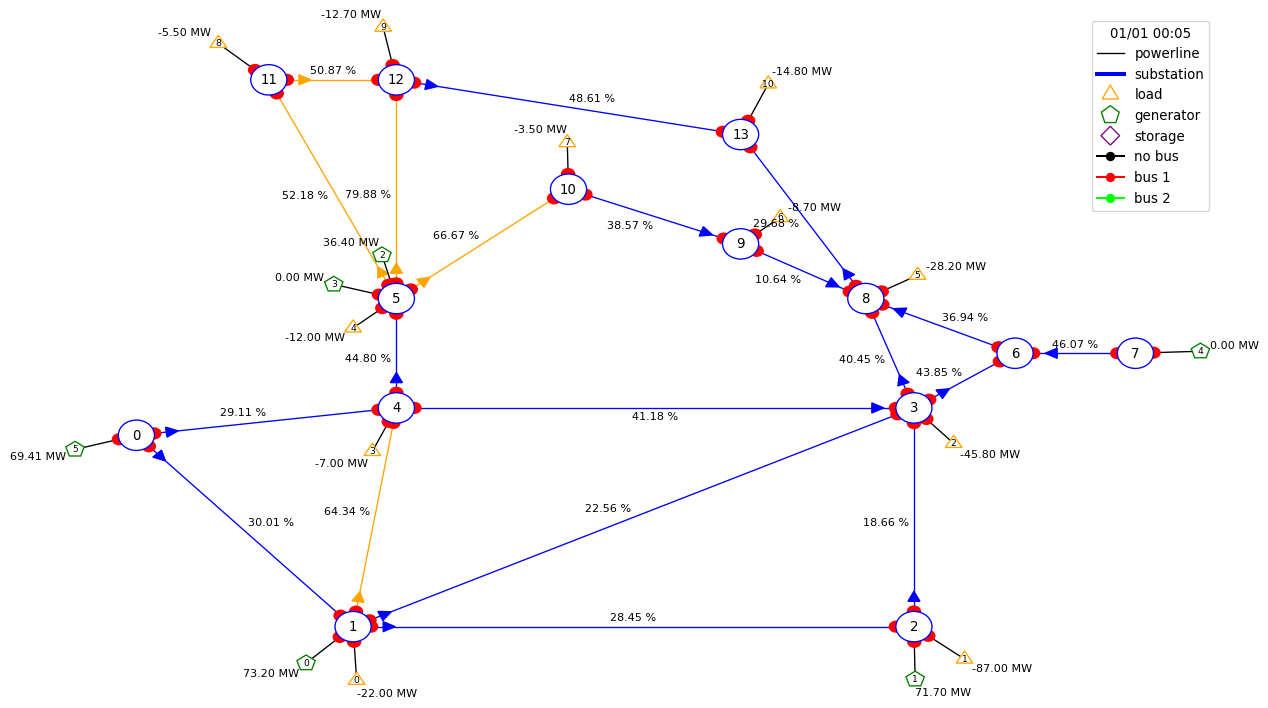

In [5]:
# The environment should be create for first time to be visualized
dataset.create_environment(env_name="l2rpn_case14_sandbox", use_lightsim_if_available=True)
dataset.visualize_network()

Once an object of the class `GenerateData` is instanciated (we call it a `generator`), we can generate various distributions for the same experiment. The generator object performe the data generation by calling `generate` function and passing a set of parameters to this function, such as :
- nb_samples : the number of observations 
- tag : indicates the goal of the generated dataset (training, validation, test, super_test)
- reference_number : a number indicating the reference topology of the network, a code book is provided below 
- ***jerome***: *reference_number* an identifier might be better than a number for readability? (for ex: 0=fully_meshed, 1=one_disconnected_line, 2=topo_change_at_3, 3=topo_change_at_5, 4=topo_changes_at_3_and_5)
| reference_number | Description |
| :- | :- |
| 0 | the reference topology corresponds to a a fully meshed network |
| 1 | the reference topology presents a disconnected line (line 3 which connectes nodes 1 and 3) |
| 2 | the reference topology presents a topological change at a node in the network (node 3) |
| 3 | the reference topology presents a topological change at another node of the network (node 5) |
| 4 | the reference topology presents a topological changes at two nodes of the networks (nodes 3 & 5) |
- agent_generator_name : an agent which can take some actions during the power network life span and which controls the data distribution, the list of possible agents and their descriptions are indicated in the table below
| agent_generator_name | Description |
| :- | :- |
| do_nothing | an agent that does not change the state of the network |
| random_nn1 | an agent that disconnects a line with the probability of p as parameter |
| random_n1 | an agent that disconnects a line |
| random_n2 | an agent that disconnects two lines |
| random_tc_nn1 | an agent that performs a topological change at a node of the network with probability of p |
| random_tc_n1 | an agent that performs a topological change at a node of the network |
| random_tc_n2 | an agent that performs a topological change at two nodes of the network |
- skip_gameover : whether to consider the gameover situations during data generation or not. The consideration of this situations is the purpose of another benchmark and can be used for a classification task

#### Load from file
We can load the stored data via the`load` function, to reuse the already generated dataset and to save some time for further experiments.

In [4]:
dataset.load(path=OUTPUT_DIR)

C:\Users\milad.leyli-abadi\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
C:\Users\milad.leyli-abadi\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
C:\Users\milad.leyli-abadi\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_pos\"], they have been replaced by 0")


#### Save to file

We can save the generated data to the file system via the `save` function, for futur reuse in further experiments.

In [8]:
dataset.save(path=OUTPUT_DIR)

####  Generate data from scratch

In the following we generate 4 datasets with different distributions : 
- *training dataset* : considering random_nn1 agent as generator, the training dataset with over 1 million of examples, presents a distribution including the disconnection of one line or fully meshed network at each iteration. This dataset is used only for training of a model based on machine learning (neural networks);

In [10]:
dataset.generate(env_name="l2rpn_case14_sandbox",
                 nb_samples=int(1024) * int(256), # attention, it takes a while to generate this size of data
                 tag="training", # this tag indicates that the data is used for training and preprocessing
                 attr_names=("prod_p", "prod_v", "load_p", "load_q", "line_status", "topo_vect",
                             "a_or", "a_ex", "p_or", "p_ex", "q_or", "q_ex", "prod_q", "load_v", 
                             "v_or", "v_ex"),
                 reference_number=0, 
                 agent_generator_name="random_nn1",
                 skip_gameover=True,
                 _nb_obs_init=512 # this parameter indicates how many observations should be used for initialization of an augmented simulator
                 )

100%|██████████| 1048576/1048576 [29:38<00:00, 589.45it/s]


- *validation* : a dataset with the same distribution of training set with less number of examples for the validation of neural networks which allows to analyze the convergence of the model;

<span style="color:red"> validation is not yet implemented in new version </span>

In [11]:
dataset.generate(env_name="l2rpn_case14_sandbox",
                 nb_samples=int(1024) * int(128), # attention, it takes a while to generate this size of data
                 tag="validation", # this tag indicates that the data is used for training and preprocessing
                 attr_names=("prod_p", "prod_v", "load_p", "load_q", "line_status", "topo_vect",
                             "a_or", "a_ex", "p_or", "p_ex", "q_or", "q_ex", "prod_q", "load_v", 
                             "v_or", "v_ex"),
                 reference_number=0, 
                 agent_generator_name="random_nn1",
                 skip_gameover=True
                 )

100%|██████████| 131072/131072 [03:44<00:00, 584.35it/s]


- *test* : a test set to evaluate the performance of the trained models or physics solver like DC approximator which presents the same distribution as the training set;

In [12]:
dataset.generate(env_name="l2rpn_case14_sandbox",
                 nb_samples=int(1024) * int(128), 
                 tag="test", # this tag indicates that the data is used for evaluation (same distribution of training dataset)
                 attr_names=("prod_p", "prod_v", "load_p", "load_q", "line_status", "topo_vect",
                             "a_or", "a_ex", "p_or", "p_ex", "q_or", "q_ex", "prod_q", "load_v", 
                             "v_or", "v_ex"),
                 reference_number=0, 
                 agent_generator_name="random_n1",
                 skip_gameover=True
                 )

100%|██████████| 131072/131072 [03:57<00:00, 551.56it/s]


- *super_test* : to evaluate the generalisation of different models for the inference of out-of-distribution examples. A different generator agent is used for this dataset that allows to disconnect two power lines simultaneously and corresponds to a distribution that has never been seen during the training and validation phases.

In [15]:
dataset.generate(env_name="l2rpn_case14_sandbox",
                 nb_samples=int(1024) * int(128), 
                 tag="super_test", # this tag indicates that the data is used for evaluation (out-of-distribution dataset)
                 attr_names=("prod_p", "prod_v", "load_p", "load_q", "line_status", "topo_vect",
                             "a_or", "a_ex", "p_or", "p_ex", "q_or", "q_ex", "prod_q", "load_v", 
                             "v_or", "v_ex"),
                 reference_number=0, 
                 agent_generator_name="random_n2",
                 skip_gameover=True
                 )

C:\Users\milad.leyli-abadi\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
C:\Users\milad.leyli-abadi\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
C:\Users\milad.leyli-abadi\Anaconda3\envs\RTE\lib\site-packages\lightsim2grid\_aux_add_trafo.py:46: UserWarning: There were some Nan in the pp_net.trafo["tap_pos"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_pos\"], they have been replaced by 0")
100%|█████████████████████████████████████████████████████████████████████████| 131072

- *test_simple* : a simple test set using `do_nothing` agent for DC approximation

In [14]:
dataset.generate(env_name="l2rpn_case14_sandbox",
                 nb_samples=int(1024) * int(128), 
                 tag="super_test", # this tag indicates that the data is used for evaluation (same distribution of training dataset)
                 attr_names=("prod_p", "prod_v", "load_p", "load_q", "line_status", "topo_vect",
                             "a_or", "a_ex", "p_or", "p_ex", "q_or", "q_ex", "prod_q", "load_v", 
                             "v_or", "v_ex"),
                 reference_number=0, 
                 agent_generator_name="do_nothing",
                 skip_gameover=True
                 )

100%|██████████| 4096/4096 [00:05<00:00, 744.95it/s]


#### Save to file 
We can store the generated data on disk using `save` function and reload them when we require them.

In [16]:
dataset.save(path=OUTPUT_DIR)

<b>Network reference topology visualisation function</b> : to see the network configuration and reference topology, we can visualize the selected power network via the following function.

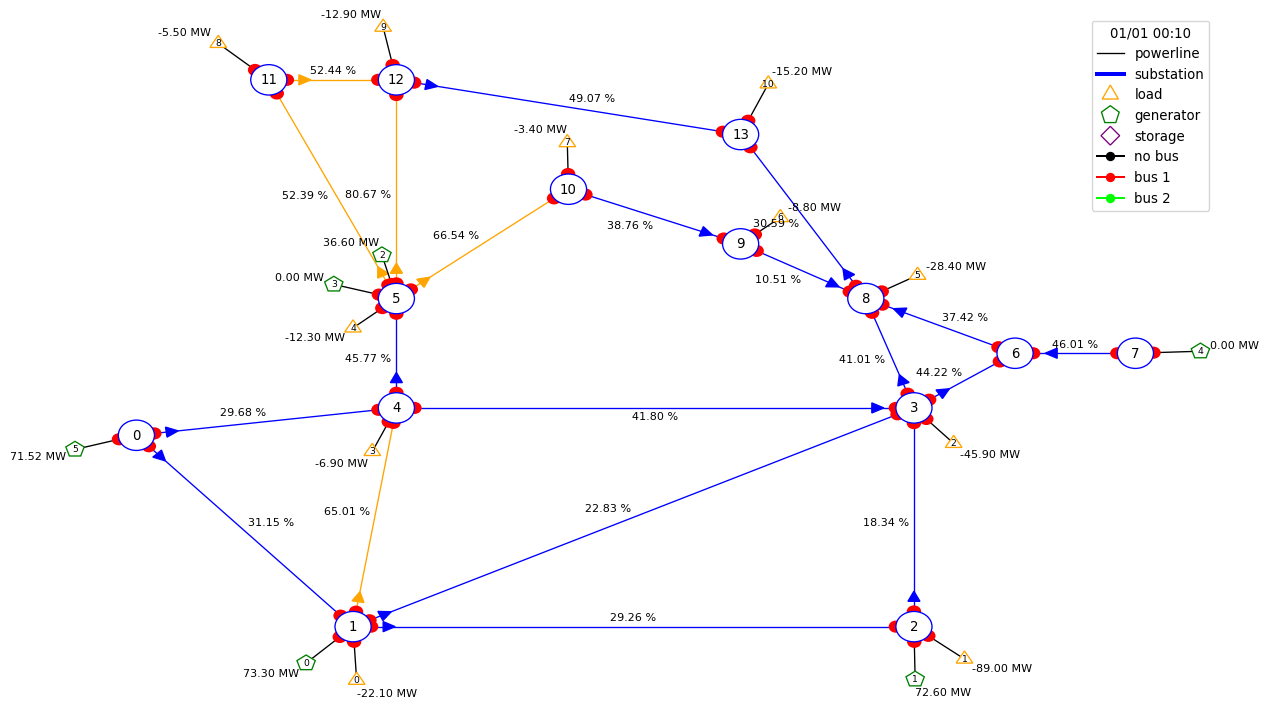

In [7]:
dataset.visualize_network_reference_topology(tag="training")

As it can be observed the reference topology corresponds to a fully meshed power network. All the lines are connected and all the element are connected to busbar 1.

In [8]:
print("Available datasets : ", dataset.dataset_available)
print("Dataset sizes : ", dataset.dataset_size)
print("dataset tags : ", dataset.tag_list)
print("Reference action description : \n", dataset.reference_number)

Available datasets :  {'training': True, 'test': True, 'super_test': True}
Dataset sizes :  {'training': 262144, 'test': 131072, 'super_test': 131072}
dataset tags :  ['training', 'test', 'super_test']
Reference action description : 
 {'training': 0, 'test': 0, 'super_test': 0}


In [9]:
# different available variables with their corresponding lengths
dataset.variable_size

{'prod_p': 6,
 'prod_v': 6,
 'load_p': 11,
 'load_q': 11,
 'line_status': 20,
 'topo_vect': 57,
 'a_or': 20,
 'a_ex': 20,
 'p_or': 20,
 'p_ex': 20,
 'q_or': 20,
 'q_ex': 20,
 'prod_q': 6,
 'load_v': 11,
 'v_or': 20,
 'v_ex': 20}

We can see that the training dataset could have a line disconnection from time to time, which is the result of data generation while using a `RandomNN1` agent which disconnects a power line with a probability of `p=0.5` in this case.

In [10]:
# to verify if the actions are taken into account
print(np.sum(dataset.dataset["training"]["line_status"],axis=1)[:20])

[19. 19. 20. 20. 20. 20. 20. 19. 19. 20. 19. 20. 20. 20. 19. 19. 20. 19.
 19. 20.]


We can see below that the test dataset presents two disconnections for each sample of the dataset. This situation was never been observed during the training and is an out-of-distribution situation. 

In [11]:
print(np.sum(dataset.dataset["test"]["line_status"],axis=1)[:20])
print(np.sum(dataset.dataset["super_test"]["line_status"],axis=1)[:20])

[19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19.]
[18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18.]


### Create an augmented simulator 
An augmented simulator should be built using a sub-class of `AugmentedSimulator` class. In this case, we use `LeapNet` augmented simulator which is based on neural networks and allows to take into account the topology changes and lines connection/disconnection in latent space. To create an augmented simulator, one should indicate the inputs and output attributes. Concerning `LeapNet` architecture, it takes a third parameter which is topology and should be indicated. <span style="color:red">It is mendatory that a model to be built before passing it to Benchmark</span>

To create a benchmark on the generated data, we should pass a GenerateData object as parameter to Benchmark class. The other attributes of the Benchmark class indicates the variables should be used among the inputs and outputs of a model. 

The table below indicate the exhaustive list of inputs and outputs that can be considered for any model.

| Input variables | Description | - | Output variables | Description |
| :- | :- | :- | :- | :- |
| prod_p | production active power MW |   | <b>a_or & a_ex</b> | current at two extremities of a power line |
| prod_v | production voltage KV |  | v_or & v_ex | voltages at two extremities of power lines  |
| load_p | load active power MW |   | p_or & p_ex | active powers at two extremities of power lines |
| load_q | load reactive power Mvar |   | q_or & q_ex | reactive powers at two extremities of power lines |
| line_status| binary vector indicating if a line is connected |   | load_v | load voltage in KV |
| | | | prod_q | production reactive power in MVar |

For the sake of this benchmark, we use all the inputs. However, only the currents are required to be predicted as the objective is to assess the risk through contingency screening and an overload is detected if the value of current $a_{or}$ exceeds a threshold that depends on each line.

In [5]:
leap_net = LeapNet(attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                   attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or", "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                   attr_tau=("line_status",),
                   layer=ResNetLayer,
                   sizes_enc=(20, 20, 20),
                   sizes_main=(150, 150, 150),
                   sizes_out=(100, 40),
                   lr=1e-4,
                   loss="mse"
                  )

<b>Initialize and build the augmented simulator (aka model)</b> An augmented simulator should be initialized and built. This is possible through two function `init` and `build_model` of an augmented simulator which give the flexibility to user to defin its desired set of parameters (e.g., number of layers, number of neurons, training loss, etc.). 

For exhaustive list of set of available parameters, look at the documentation of the platform.

In [23]:
leap_net.init(dataset.init_obs)

In [24]:
leap_net.build_model()

<b>Access the model</b> The built model is available using `_model` member of `LeapNet` class. One can verify its architecture using the following command

In [25]:
leap_net._model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_prod_p (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
x_prod_v (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
x_load_p (InputLayer)           [(None, 11)]         0                                            
__________________________________________________________________________________________________
x_load_q (InputLayer)           [(None, 11)]         0                                            
______________________________________________________________________________________________

<b>Load the augmented simulator</b> One can also reload an already trained augmented simulator via its `load` function

In [6]:
model_path = os.path.join(OUTPUT_DIR,"Scenario1", "Benchmarks", "benchmark1", "leap_net")
leap_net.load(path=model_path)

logically, it can also be saved once its trained in the context of a benchmark whether using the Benchmark `save_augmentedSimulator` function (recommended) or using its specific functions which are `leap_net._save_metadata` and `leap_net.save_data`.

### Create a benchmark
Once the data generated using `GenerateData` class, the data are passed to the `Benchmark` class via an object. In Benchmark class, the user could select the inputs and outputs that should be considered for modeling purpose. This module gives the flexibility to select a desired model among the available models (or to be implemented and to be imported by the user). The already developed models are a DC approximator and three neural network based models which are : LeapNet, ResNet and fully connected models. The benchmark class gives the ability to train the models (with the exception of DC approximator which does not require to be trained) and to predict the observations in test datasets. The benchmark results could also be saved and be reloaded for further investigations. Finally, in order to evaluate the performance of the designed benchmark, an object of this class should be passed to Evaluate class, whih in turn provides different domain specific and generic metrics and criteria.
![Benchmarking step](img/Benchmarking.png)

#### Build a statistical learning model (Deep Neural Network)
Once the benchmark is created, if we would like to create a model based on neural nets, users should firstly build a model via `build_model` function. The benchmark platform give the flexibiltiy to users to import their own Tensorflow Model and pass as a parameter to build function of Benchmark class. Afterward, other model specific parameters such as number of layers and neurons, optimizer, loss and metrics could also be customized.

<span style="color:red">The benchmark class will be updated in next version to take as input the Evaluation class object</span>

In [7]:
benchmark_ML = Benchmark(benchmark_name="benchmark1",
                         dataset = dataset, # an object of DataSet class
                         augmentedSimulator = leap_net, # an object of LeapNet model
                         attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                         attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                 "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                         attr_tau=("line_status",),
                         path=OUTPUT_DIR
                        )

***jerome:*** pourquoi "benchmark2" ? -> confusion avec les noms des benchmarks "applicatifs"
-> plutôt "benchmark-ml_leapnet" par ex.

#### Train the neural network model
The benchmark offers the facilities to train the augmented simulator using its `train_model` function. It deals with creation of data batches which are thereafter are sent to augmented simulator for learning.

In [21]:
benchmark_ML.train_model(epochs=10, batch_size=32, verbose=1, save_model=True)

100%|████████████████████████████████████████████████████████████████████████████| 81920/81920 [26:41<00:00, 51.14it/s]


<b>Save the augmented simulator via Benchmark class</b> : the benchmark class gives the possibility to save the trained augmented simulator via `save_augmentedSimulator` function. We recommend to not consdier a path and choose the default saving path, which is organized in the corresponding benchmark and model's directories.

In [ ]:
benchmark_ML.save_augmentedSimulator()

<b>Save the benchmark</b> : the benchmark could be saved for further investigations

In [23]:
benchmark_ML.save()

<b>Load the benchmark : </b> the benchmark and its parameters could be load from file using `load` function.

In [36]:
#benchmark.load(path=os.path.join(OUTPUT_DIR,"Scenario1","Benchmarks"))
benchmark_ML.load(path=os.path.join(OUTPUT_DIR,"Scenario1","Benchmarks","benchmark1"))

<b>Analysis and visualisation tools : </b> The platform offers a set built-in visualisation and analysis tools to study the model's behavior. As an example, we have visualized the convergence curves using the training and validation datasets. In this graphic, the x-axis corresponds to the epochs and y-axis corresponds to the loss values which is in this case Mean Squared Error (MSE). It should alos be noted that the loss values are averaged over different steps of an epoch.  

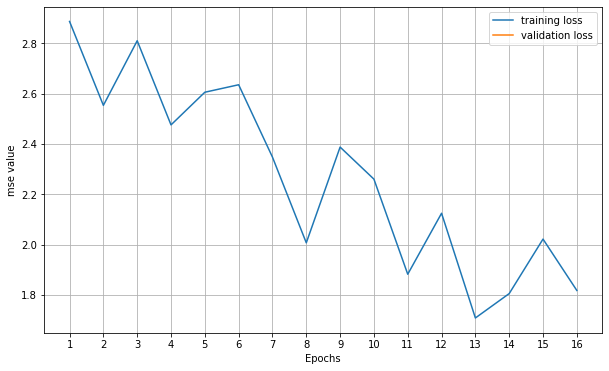

In [22]:
benchmark_ML.plot_convergence()

From the convergence plot, we can note if the model has been converged towards the optimal solution and if there was an over or under fitting problem by considering both training and validation losses.

#### Predict using the trained model 
Once the model is learnt, it can be used to make inference on test data which have never been seen during the training phase. 

<b>Important note : </b>It should be noticed that the platform gives the flexibility to the users to generate multiple test datasets with various distributions and to add a unique tag for each generated dataset. When we would to call the prediction function, the tag parameter should point to the test dataset on which we want make the predictions.

In [24]:
benchmark_ML.model_predict(tag="test", batch_size=1024, verbose=1, save_predictions=True)

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:08<00:00, 15.81it/s]


Predictions saved successfully !


In [25]:
benchmark_ML.model_predict(batch_size=1024,tag="super_test", verbose=1, save_predictions=True)

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:08<00:00, 15.02it/s]


Predictions saved successfully !


#### DC approximation

In [25]:
benchmark_dc = Benchmark(benchmark_name="benchmark_dc",
                         dataset = dataset,
                         attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                         attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                 "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                         attr_tau=("line_status",),
                         path=OUTPUT_DIR
                        )

##### Evaluate DC approximation 
As the DC approximator does not require to be learned, a specific evaluation function is designed for this solver. It is also considered as the baseline model for all the comparisons. The `evaluate_dc` function, in its simplest form gets a `tag` of a dataset (corresponding to one of the test datasets) and the `save_path` parameter to save the prediction results. Once, the evaluation is completed, the prediction results will be accessible via `predictions` variable and corresponding true variables are also stored in `observations` variable. These two variables are dictionaries with first level keys representing the tag of a dataset and second level keys representing the name of the predicted variables indicated in `attr_y` argument of `evaluate_dc` function. 

In [26]:
benchmark_dc.evaluate_dc(tag = "test_simple", save_evaluation=True)

100%|██████████| 4096/4096 [01:27<00:00, 46.93it/s]

Predictions saved successfully !


In [27]:
benchmark_dc.evaluate_dc(tag = "test", save_evaluation=True)

100%|██████████| 131072/131072 [1:12:26<00:00, 30.16it/s]


Predictions saved successfully !


In [28]:
benchmark_dc.evaluate_dc(tag = "super_test", save_evaluation=True)

100%|██████████| 131072/131072 [1:15:24<00:00, 28.97it/s]


Predictions saved successfully !


### Evaluation
The third important module of the LIPS platform is the Evaluation module, which aims at evaluating the performance of trained models with respect to various criteria. Each criterion tackles a particular point of view which are

- <b>physics compliances </b> Four functions are developed to evaluate the physics based electricity laws. These functions could be called through `evaluate_physic` function of the `Evaluation` class (by passing True for corresponding verification) and are :
    - BasicVerifier : it performs some elementray verification on different aspect of the network, which are the following:
        * verifying the positivity of current values $\hat{a}_{or} > 0$ and $\hat{a}_{ex} > 0$
        * verifying the positivity of voltage values $\hat{v}_{or} > 0$ and $\hat{v}_{ex} > 0$
        * verifying the positivity of electrical loss (EL) $\hat{p}_ex + \hat{p}_or > 0$. A critierion $-\sum_t \min(EL_t, 0)$ is computed to measure the influence of negative values.
        * verifying the zero values for current, active and reactive powers (a, p and q) in the case of power line disconnection
        * verifying the following equations by computing the divergence between left and right hand side of the equations using Mean Absolute Error (MAE), the denominator is added by an epsilon (very small value) to avoid the division by zero in the case where the voltages are equal to zero $v=0$
            * $a_{or} = \frac{\sqrt{p_{or}^2 + q_{or}^2}}{\sqrt{3}\cdot v_{or}+ \epsilon}$ 
            * $a_{ex} = \frac{\sqrt{p_{ex}^2 + q_{ex}^2}}{\sqrt{3}\cdot v_{ex}+ \epsilon}$
    - Check_loss : it verifies if the ratio of electrical loss wrt the production active power $\frac{\hat{p}_{or} + \hat{p}_{ex}}{p_{prod}}.$. This ratio is acceptable if it is situated in the range [1,4] percents. It returns the electrical loss values and the indices of the observations which do not respect the acceptable range.
    - Check_energy_conservation: it verifies the law of conservation of energy (called also LCE) where the productions should be equal to consumptions and electrical loss, or in other words : $p_{prod} = p_{load} + (\hat{p}_{or} + \hat{p}_{ex})$. It returns the LCE values which is : $LCE = p_{prod} - p_{load} - (\hat{p}_{or} + \hat{p}_{ex})$ and the indices of the observation which does not respect this law at an indicated tolerance.
    - Check_Kirchhoff_current_law: It verifies the Kirchoff's current law. The sum of complex currents (computed via active and reactive powers) entering a node should be equal to sum of the exiting complex currents from that node. It returns the law values computed at each node, added at the network level and the indices of the observations which does not respect the law.


- <b>Machine Learning metrics :</b> various metrics are included to evaluate the performance of the models from accuracy and time complexity point of view.
    - MAPE90 : same as Mean Absolute Percentage Error (MAPE), except that the error is computed on the 10% of lines with the highest current values. The prediction of high current values is important to ensure the security of power networks;
    -Time complexity (in seconds) : time required for evaluation phase of the models (prediction of power flows).
    - metrics such as MAE, MSE, NRMSE, MAPE, etc.
    
    
- <b>Adaptability : </b> TO BE DISCUSSED AND IMPLEMENTED


- <b>Readiness : </b> TO BE DISCUSSED AND IMPLEMENTED
![Evaluation phase](img/Evaluation.png)

#### Evaluate the neural network based model 

In [26]:
evaluator_nn = Evaluation(benchmark_ML, tag="test")

##### Evaluate on test set (same distribution as the training set)

<b>ML-related criteria</b>

In [27]:
evaluator_nn.evaluate_ML(compute_metricsPercentage=True, # whether to compute the metrics on a percentage of data with highest current values
                         metric_percentage=["mape", "MAE"], # the metrics used for this purpose
                         k=0.1,
                         verbose=0) # the proportion of data to be considered for this metric

In [28]:
print("Inference time of the selected model : ", evaluator_nn.metrics_ML["test_time"])
print("NRMSE : ")
pprint(evaluator_nn.metrics_ML["NRMSE_avg"])
print("Mean Absolute Percentage Error averaged over all the nodes : ") 
pprint(evaluator_nn.metrics_ML["mape_avg"])
print("MAPE90")
pprint(evaluator_nn.metrics_ML["mape10"])

Inference time of the selected model :  47.529518604278564
NRMSE : 
{'a_ex': 0.1214992904035355,
 'a_or': 0.10241470556391963,
 'load_v': 0.01704199159429766,
 'p_ex': 0.023446851850938984,
 'p_or': 0.021112399098965742,
 'prod_q': 0.02000103294312511,
 'q_ex': 0.018516473878021338,
 'q_or': 0.023492782683495275,
 'v_ex': 0.0052709125650113675,
 'v_or': 0.003338215706405791}
Mean Absolute Percentage Error averaged over all the nodes : 
{'a_ex': 0.26441642331804216,
 'a_or': 0.2243237157497211,
 'load_v': 0.0006101506172344148,
 'p_ex': 0.06597693074965384,
 'p_or': 0.05791706121228797,
 'prod_q': 0.017403664237342242,
 'q_ex': 0.05020009407399849,
 'q_or': 0.05641401009571969,
 'v_ex': 0.003043628383688786,
 'v_or': 0.0015387762660086155}
MAPE90
{'a_or': 0.139688865563781,
 'p_or': 0.033595592377144136,
 'q_or': 0.05424285850337955,
 'v_or': 0.0013802483325541912}


<b>Physics compliances</b>

In [29]:
evaluator_nn.evaluate_physic(choice="real")

************* Basic verifier *************
Current positivity check passed for origin side !
----------------------------------------------
Current positivity check passed for extremity side !
----------------------------------------------
Voltage positivity check passed for origin side !
----------------------------------------------
Voltage positivity check passed for extremity side !
----------------------------------------------
1.490% of lines does not respect the positivity of loss (Mw)
Concerned lines with corresponding number of negative loss values:
 {18: 33903, 15: 3319, 19: 1844}
----------------------------------------------
Prediction in presence of line disconnection. Check passed !
----------------------------------------------
************* Check loss *************
Verification is done without any violation !
************* Check Energy Conservation *************
Number of failed cases is 0 and the proportion is 0.000% : 
************* Check kirchhoff's current law *****

In [30]:
evaluator_nn.evaluate_physic(choice="predictions")

************* Basic verifier *************
0.930% of lines does not respect the positivity of currents (Amp) at origin
Concerned lines with corresponding number of negative current values at their origin:
 {5: 17778, 4: 1933, 14: 1801, 13: 1298, 1: 1030, 10: 367, 6: 154, 0: 25}
----------------------------------------------
0.316% of lines does not respect the positivity of currents (Amp) at extremity
Concerned lines with corresponding number of negative current values at their extremity:
 {13: 5041, 14: 1281, 1: 1091, 2: 406, 10: 307, 0: 78, 11: 49, 18: 11, 19: 9, 17: 8, 5: 3, 9: 2, 16: 1}
----------------------------------------------
Voltage positivity check passed for origin side !
----------------------------------------------
Voltage positivity check passed for extremity side !
----------------------------------------------
43.021% of lines does not respect the positivity of loss (Mw)
Concerned lines with corresponding number of negative loss values:
 {6: 93176, 19: 92302, 16: 92

#####  Evaluate on super test (out-of-distribution)

In [31]:
evaluator_nn = Evaluation(benchmark_ML, tag="super_test")

In [32]:
evaluator_nn.evaluate_ML(verbose=0)

In [33]:
print("Inference time of the selected model : ", evaluator_nn.metrics_ML["test_time"])
print("NRMSE : ")
pprint(evaluator_nn.metrics_ML["NRMSE_avg"])
print("Mean Absolute Percentage Error averaged over all the nodes : ") 
pprint(evaluator_nn.metrics_ML["mape_avg"])
print("MAPE90")
pprint(evaluator_nn.metrics_ML["mape10"])

Inference time of the selected model :  47.529518604278564
NRMSE : 
{'a_ex': 0.21503193581758645,
 'a_or': 0.16250921842045768,
 'load_v': 0.1435118985173922,
 'p_ex': 0.12691801059082952,
 'p_or': 0.12755651741361057,
 'prod_q': 0.07065890093307221,
 'q_ex': 0.11159467515786141,
 'q_or': 0.11220981152063558,
 'v_ex': 0.2068165984620213,
 'v_or': 0.04445904252204429}
Mean Absolute Percentage Error averaged over all the nodes : 
{'a_ex': 0.5106735642209558,
 'a_or': 0.37007746878797165,
 'load_v': 0.006985089107506953,
 'p_ex': nan,
 'p_or': nan,
 'prod_q': 0.08650225406152412,
 'q_ex': 0.36122790621301215,
 'q_or': 0.3967485934658115,
 'v_ex': 0.031312853571392435,
 'v_or': 0.0052181056493556975}
MAPE90
{'a_or': 0.25019765699701996,
 'p_or': 0.2739691945790183,
 'q_or': 0.2846574463013456,
 'v_or': 0.007154778142489928}


In [34]:
evaluator_nn.evaluate_physic(choice="predictions")

************* Basic verifier *************
2.612% of lines does not respect the positivity of currents (Amp) at origin
Concerned lines with corresponding number of negative current values at their origin:
 {5: 25580, 14: 6846, 1: 5187, 3: 4768, 2: 4640, 4: 3248, 6: 2854, 11: 2679, 10: 2615, 13: 1719, 0: 1566, 15: 1284, 16: 1279, 18: 1122, 9: 982, 19: 948, 17: 726, 7: 295, 8: 129}
----------------------------------------------
3.643% of lines does not respect the positivity of currents (Amp) at extremity
Concerned lines with corresponding number of negative current values at their extremity:
 {2: 24881, 13: 10538, 18: 10223, 0: 9838, 1: 8892, 4: 5987, 14: 4608, 19: 3964, 5: 3553, 10: 3333, 11: 2607, 3: 2533, 6: 1397, 8: 1042, 17: 794, 7: 632, 9: 550, 15: 115, 16: 4}
----------------------------------------------
0.000% of lines does not respect the positivity of voltages (Kv) at origin
Concerned lines with corresponding number of negative voltage values at their origin:
 {7: 4}
--------

#### Evaluate the DC approximator (do_nothing agent)

In [40]:
evaluator_dc = Evaluation(benchmark_dc, tag="test_simple")

#####  ML-related criteria

In [41]:
evaluator_dc.evaluate_ML(compute_metricsPercentage=True, # whether to compute the metrics on a percentage of data with highest current values
                         metric_percentage=["mape", "MAE"], # the metrics used for this purpose
                         k=0.1,# the proportion of data to be considered for this metric
                         verbose=0) 

In [42]:
print("Inference time of the selected model : ", evaluator_dc.metrics_ML["test_time"])
print("Mean Absolute Percentage Error averaged over all the nodes : ") 
pprint(evaluator_dc.metrics_ML["mape_avg"])
print("MAPE90")
pprint(evaluator_dc.metrics_ML["mape10"])

Inference time of the selected model :  2619.110010623932
Mean Absolute Percentage Error averaged over all the nodes : 
{'a_ex': 0.21725693153428485,
 'a_or': 0.22909624045996207,
 'load_v': 0.032809324246772055,
 'p_ex': 0.10102460747844037,
 'p_or': 0.10586949439092552,
 'prod_q': 0.728586030573572,
 'q_ex': 1.0,
 'q_or': 1.0,
 'v_ex': 0.03347927429835744,
 'v_or': 0.02145334285880384}
MAPE90
{'a_or': 0.5128504091568424,
 'p_or': 0.04052962580742235,
 'q_or': 1.0,
 'v_or': 0.046387804873254695}


##### Physics compliances

In [43]:
evaluator_dc.evaluate_physic(choice="real")

************* Basic verifier *************
Current positivity check passed for origin side !
----------------------------------------------
Current positivity check passed for extremity side !
----------------------------------------------
Voltage positivity check passed for origin side !
----------------------------------------------
Voltage positivity check passed for extremity side !
----------------------------------------------
0.781% of lines does not respect the positivity of loss (Mw)
Concerned lines with corresponding number of negative loss values:
 {18: 640}
----------------------------------------------
Prediction in presence of line disconnection. Check passed !
----------------------------------------------
************* Check loss *************
Verification is done without any violation !
************* Check Energy Conservation *************
Number of failed cases is 0 and the proportion is 0.000% : 
************* Check kirchhoff's current law *************
0.00% not ver

In [44]:
evaluator_dc.evaluate_physic(choice="predictions")

************* Basic verifier *************
Current positivity check passed for origin side !
----------------------------------------------
Current positivity check passed for extremity side !
----------------------------------------------
Voltage positivity check passed for origin side !
----------------------------------------------
Voltage positivity check passed for extremity side !
----------------------------------------------
Loss positivity check passed !
----------------------------------------------
Prediction in presence of line disconnection. Check passed !
----------------------------------------------
************* Check loss *************
Verification is done without any violation !
************* Check Energy Conservation *************
Number of failed cases is 4096 and the proportion is 100.000% : 
************* Check kirchhoff's current law *************
7.14% not verify the Kirchhoff's current law at 0.01 tolerance


## Scenario 2 : Reference topology presenting on disconnected line

In [54]:
generator_2 = GenerateData(experiment_name="Scenario2",
                           env_name="l2rpn_case14_sandbox",
                           attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                           attr_tau=("line_status", "topo_vect"),
                           attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                   "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                           use_lightsim_if_available=True
                          )

/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_check_legit.py:49: UserWarning: Pandapower network with sn_mva != 1 are not fully supported yet, especially in the conversion for some trafo (and probably somewhere else too)
  warnings.warn("Pandapower network with sn_mva != 1 are not fully supported yet, especially in the "
/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
/home/jerome/minico

<b>Reference number 1 :</b> network presents a power line disconnection as reference topology

In [55]:
generator_2.generate(nb_samples=int(1024) * int(4),
                     tag="training",
                     reference_number=1,
                     agent_generator_name="random_nn1",
                     skip_gameover=True)

100%|██████████| 4096/4096 [00:07<00:00, 571.21it/s]


In [56]:
generator_2.generate(nb_samples=int(1024) * int(4),
                     tag="validation",
                     reference_number=1,
                     agent_generator_name="random_nn1",
                     skip_gameover=True)

100%|██████████| 4096/4096 [00:07<00:00, 566.69it/s]


In [57]:
generator_2.generate(nb_samples=int(1024) * int(2),
                     tag="test",
                     reference_number=1,
                     agent_generator_name="random_n1",
                     skip_gameover=True)

100%|██████████| 2048/2048 [00:03<00:00, 525.58it/s]


In [58]:
generator_2.generate(nb_samples=int(1024) * int(2),
                     tag="super_test",
                     reference_number=1,
                     agent_generator_name="random_n2",
                     skip_gameover=True)

100%|██████████| 2048/2048 [00:04<00:00, 434.57it/s]


In [59]:
generator_2.save(path=OUTPUT_DIR)

<b>Visualization of reference topology</b>

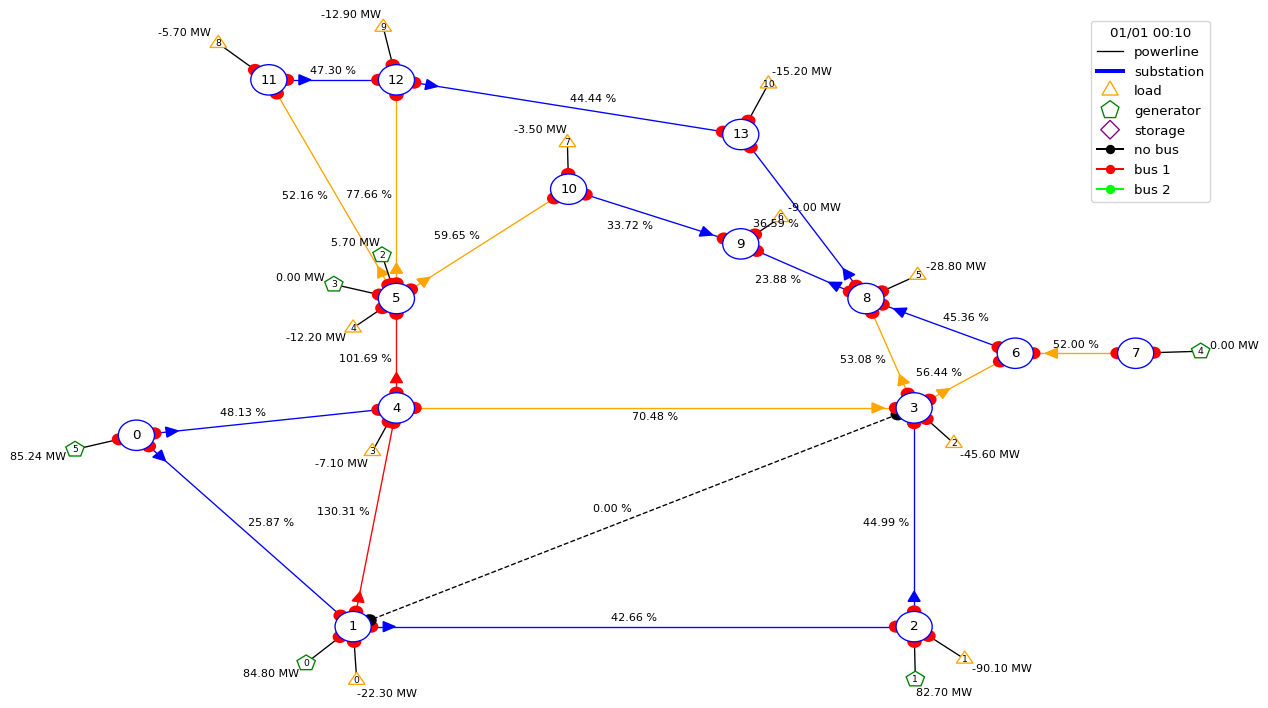

In [60]:
generator_2.visualize_network_reference_topology(tag="training")

As it can be observed, in this scenario, the reference topology present a line disconnection between nodes 1 and 3 of the power grid.

In [61]:
print(generator_2.reference_number)

{'training': 1, 'validation': 1, 'test': 1, 'super_test': 1}


In [62]:
np.sum(generator_2.dataset["training"]["line_status"],axis=1)[0:20]

array([18., 18., 19., 19., 19., 19., 19., 18., 18., 19., 18., 19., 19.,
       19., 18., 18., 19., 18., 18., 19.])

In [63]:
np.sum(generator_2.dataset["test"]["line_status"],axis=1)[0:20]

array([18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
       18., 18., 18., 18., 18., 18., 18.])

In [64]:
generator_2.dataset["training"]["topo_vect"][10]

array([ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])

In [65]:
generator_2.dataset["test"]["topo_vect"][10]

array([-1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])

## Scenario 3 : Reference topology presenting one topological change (node 3)

In [66]:
generator_3 = GenerateData(experiment_name="Scenario3",
                           env_name="l2rpn_case14_sandbox",
                           attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                           attr_tau=("line_status", "topo_vect"),
                           attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                   "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                           use_lightsim_if_available=True
                          )

/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_check_legit.py:49: UserWarning: Pandapower network with sn_mva != 1 are not fully supported yet, especially in the conversion for some trafo (and probably somewhere else too)
  warnings.warn("Pandapower network with sn_mva != 1 are not fully supported yet, especially in the "
/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
/home/jerome/minico

<b>Reference number 2 :</b> Network presents a topological change (bus change) at substation 3

In [67]:
generator_3.generate(nb_samples=int(1024) * int(4),
                     tag="training",
                     reference_number=2,
                     agent_generator_name="random_nn1",
                     skip_gameover=True)

100%|██████████| 4096/4096 [02:26<00:00, 27.95it/s]


In [68]:
generator_3.generate(nb_samples=int(1024) * int(4),
                     tag="test",
                     reference_number=2,
                     agent_generator_name="random_n1",
                     skip_gameover=True)

100%|██████████| 4096/4096 [02:23<00:00, 28.50it/s]


In [69]:
generator_3.generate(nb_samples=int(1024) * int(4),
                     tag="super_test",
                     reference_number=2,
                     agent_generator_name="random_n2",
                     skip_gameover=True)

100%|██████████| 4096/4096 [02:40<00:00, 25.51it/s]


<b>Visualization of reference topology</b>

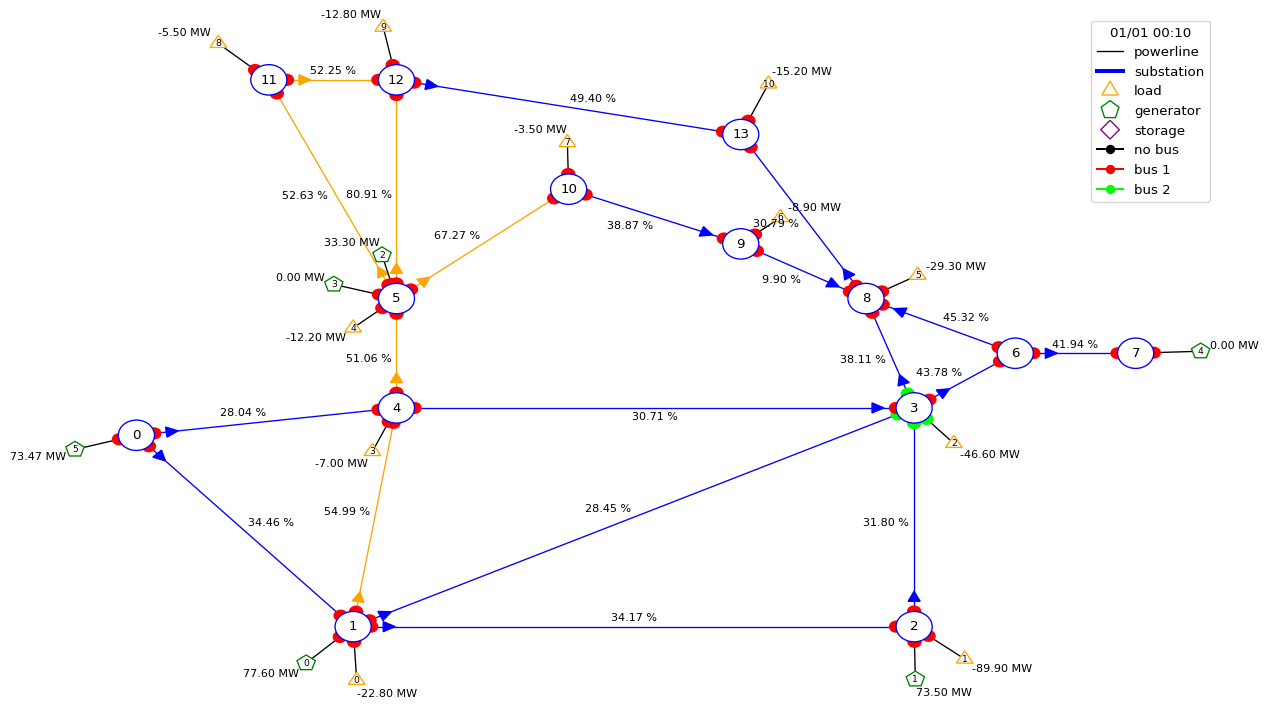

In [70]:
generator_3.visualize_network_reference_topology(tag="training")

As it can be observed, in this scenario, the reference topology presents topological changes at node 3 of the power grid.

## Scenario 4 : Reference topology presenting another topological change (node 5)

In [71]:
generator_4 = GenerateData(experiment_name="Scenario4",
                           env_name="l2rpn_case14_sandbox",
                           attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                           attr_tau=("line_status", "topo_vect"),
                           attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                   "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                           use_lightsim_if_available=True
                          )

/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_check_legit.py:49: UserWarning: Pandapower network with sn_mva != 1 are not fully supported yet, especially in the conversion for some trafo (and probably somewhere else too)
  warnings.warn("Pandapower network with sn_mva != 1 are not fully supported yet, especially in the "
/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
/home/jerome/minico

<b>Reference number 3 :</b> Network presents a topological change (bus change) at substation 5

In [72]:
generator_4.generate(nb_samples=int(1024) * int(4),
                     tag="training",
                     reference_number=3,
                     agent_generator_name="random_nn1",
                     skip_gameover=True)

100%|██████████| 4096/4096 [02:36<00:00, 26.16it/s]


In [73]:
generator_4.generate(nb_samples=int(1024) * int(4),
                     tag="test",
                     reference_number=3,
                     agent_generator_name="random_n1",
                     skip_gameover=True)

100%|██████████| 4096/4096 [02:50<00:00, 23.96it/s]


In [74]:
generator_4.generate(nb_samples=int(1024) * int(4),
                     tag="super_test",
                     reference_number=3,
                     agent_generator_name="random_n2",
                     skip_gameover=True)

100%|██████████| 4096/4096 [03:12<00:00, 21.23it/s]


<b>Visualization of reference topology</b>

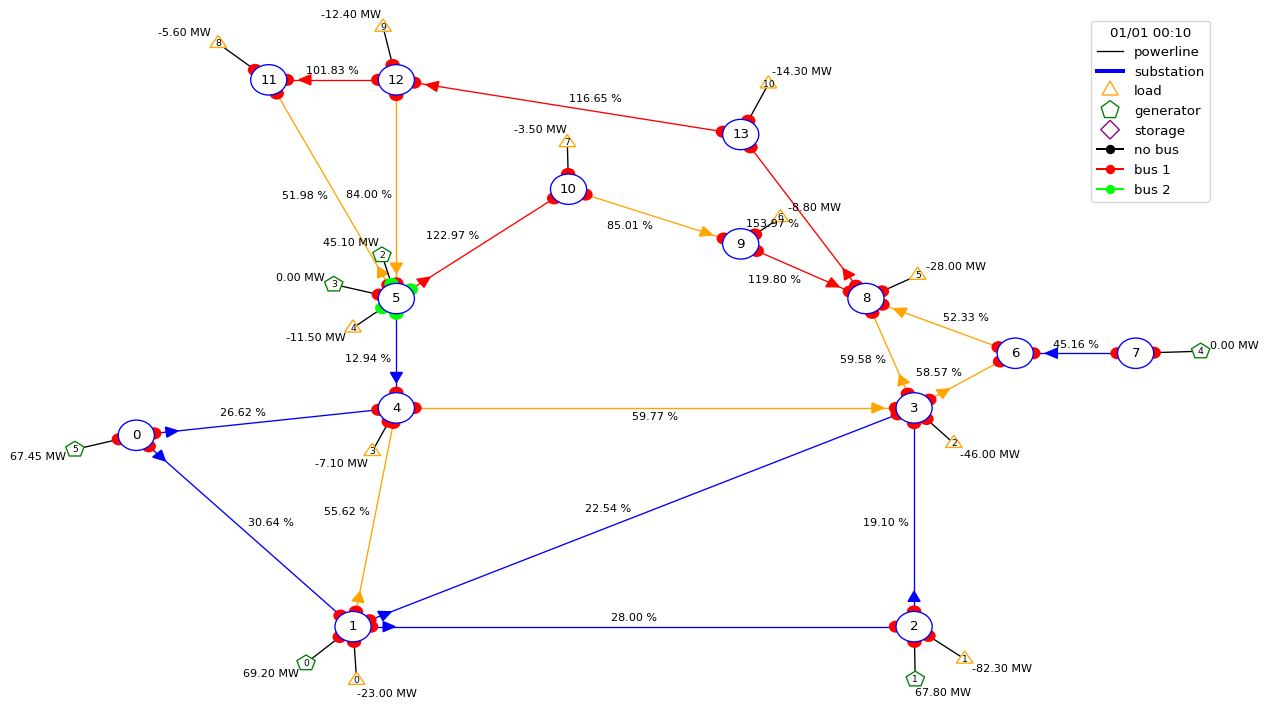

In [75]:
generator_4.visualize_network_reference_topology(tag="training")

As it can be observed, in this scenario, the reference topology presents topological changes at node 5 of the power grid.

## Scenario 5 : Reference topology presenting two simultaneous topological changes (nodes 3 and 5)

In [76]:
generator_5 = GenerateData(experiment_name="Scenario5",
                           env_name="l2rpn_case14_sandbox",
                           attr_x=("prod_p", "prod_v", "load_p", "load_q"),
                           attr_tau=("line_status", "topo_vect"),
                           attr_y=("a_or", "a_ex", "p_or", "p_ex", "q_or",
                                   "q_ex", "prod_q", "load_v", "v_or", "v_ex"),
                           use_lightsim_if_available=True
                          )

/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_check_legit.py:49: UserWarning: Pandapower network with sn_mva != 1 are not fully supported yet, especially in the conversion for some trafo (and probably somewhere else too)
  warnings.warn("Pandapower network with sn_mva != 1 are not fully supported yet, especially in the "
/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_add_trafo.py:33: UserWarning: There were some Nan in the pp_net.trafo["tap_neutral"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_neutral\"], they have been replaced by 0")
/home/jerome/miniconda2/envs/systemx/lib/python3.8/site-packages/lightsim2grid/_aux_add_trafo.py:41: UserWarning: There were some Nan in the pp_net.trafo["tap_step_percent"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_percent\"], they have been replaced by 0")
/home/jerome/minico

<b>Reference number 4 :</b> Network presents two topological changes (bus changes) at substations 3 and 5

In [ ]:
generator_5.generate(nb_samples=int(1024) * int(4),
                     tag="training",
                     reference_number=4,
                     agent_generator_name="random_nn1",
                     skip_gameover=True)

 99%|█████████▊| 4041/4096 [52:43<00:38,  1.44it/s]  

In [ ]:
generator_5.generate(nb_samples=int(1024) * int(4),
                     tag="test",
                     reference_number=4,
                     agent_generator_name="random_n1",
                     skip_gameover=True)

In [ ]:
generator_5.generate(nb_samples=int(1024) * int(4),
                     tag="super_test",
                     reference_number=4,
                     agent_generator_name="random_n2",
                     skip_gameover=True)

<b>Visualization of reference topology</b>

In [ ]:
generator_5.visualize_network_reference_topology(tag="training")

As it can be observed, in this scenario, the reference topology presents topological changes at nodes 3 and 5 of the power grid.